In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=RuntimeWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

from datetime import date
import hisepy
import numpy as np
import os
import pandas as pd
import re
import scanpy as sc

In [2]:
out_dir = 'output'
if not os.path.isdir(out_dir):
    os.makedirs(out_dir)

In [3]:
out_files = []
update_list = []

## Helper functions

In [4]:
def cache_uuid_path(uuid):
    cache_path = '/home/jupyter/cache/{u}'.format(u = uuid)
    if not os.path.isdir(cache_path):
        hise_res = hisepy.reader.cache_files([uuid])
    filename = os.listdir(cache_path)[0]
    cache_file = '{p}/{f}'.format(p = cache_path, f = filename)
    return cache_file

In [5]:
def read_csv_uuid(uuid):
    cache_file = cache_uuid_path(uuid)
    res = pd.read_csv(cache_file)
    return res

In [6]:
def read_parquet_uuid(uuid):
    cache_file = cache_uuid_path(uuid)
    res = pd.read_parquet(cache_file)
    return res

In [7]:
def read_adata_uuid(uuid):
    cache_file = cache_uuid_path(uuid)
    res = sc.read_h5ad(cache_file)
    return res

In [8]:
def backed_adata_uuid(uuid):
    cache_file = cache_uuid_path(uuid)
    res = sc.read_h5ad(cache_file, backed = 'r')
    return res

In [9]:
def rm_cache_uuid(uuid):
    cache_path = '/home/jupyter/cache/{u}'.format(u = uuid)
    rm_call = 'rm -r {d}'.format(d = cache_path)
    os.system(rm_call)

In [10]:
def format_cell_type(cell_type):
    cell_type = re.sub('\\+', 'pos', cell_type)
    cell_type = re.sub('-', 'neg', cell_type)
    cell_type = re.sub(' ', '_', cell_type)
    return cell_type

In [11]:
def filename_cell_type(filename):
    cell_type = re.sub('.+L3_','',filename)
    cell_type = re.sub('_2024.+','',cell_type)
    cell_type = re.sub('_', ' ', cell_type)
    cell_type = re.sub('pos','+', cell_type)
    cell_type = re.sub('neg','-', cell_type)
    return cell_type

In [12]:
def add_labels(adata, labels):
    obs = adata.obs
    obs = obs.reset_index(drop = True)
    obs = obs.merge(labels, on = 'barcodes', how = 'left')
    obs = obs.set_index('barcodes', drop = False)
    adata.obs = obs
    return adata

In [13]:
def propagate_hierarchy(
    adata,
    hierarchy_df,
    from_level = 'AIFI_L3',
    to_levels = ['AIFI_L2', 'AIFI_L1'],
    keep_original = True,
    original_prefix = 'predicted_'
):
    obs = adata.obs
    
    for to_level in to_levels:
        prop_df = hierarchy_df[[from_level, to_level]]
        prop_df = prop_df.drop_duplicates()
        
        if keep_original:
            obs = obs.rename({to_level: original_prefix + to_level}, axis = 1)
        else:
            obs = obs.drop(to_level, axis = 1)

        obs[from_level] = obs[from_level].astype(str)
        obs = obs.merge(prop_df, on = from_level, how = 'left')
        obs[from_level] = obs[from_level].astype('category')
        obs[to_level] = obs[to_level].astype('category')
        
    obs = obs.set_index('barcodes', drop = False)
    adata.obs = obs

    return adata

In [14]:
def element_id(n = 3):
    import periodictable
    from random import randrange
    rand_el = []
    for i in range(n):
        el = randrange(0,118)
        rand_el.append(periodictable.elements[el].name)
    rand_str = '-'.join(rand_el)
    return rand_str

## Cluster selection functions

In [15]:
def marker_frac_df(adata, markers, clusters = 'louvain_2'):
    gene_cl_frac = sc.pl.dotplot(
        adata, 
        groupby = clusters,
        var_names = markers,
        return_fig = True
    ).dot_size_df
    return gene_cl_frac

def select_clusters_above_gene_frac(adata, gene, cutoff, clusters = 'louvain_2'):
    gene_cl_frac = marker_frac_df(adata, gene, clusters)
    select_cl = gene_cl_frac.index[gene_cl_frac[gene] > cutoff].tolist()

    return select_cl

def select_clusters_below_gene_frac(adata, gene, cutoff, clusters = 'louvain_2'):
    gene_cl_frac = marker_frac_df(adata, gene, clusters)
    select_cl = gene_cl_frac.index[gene_cl_frac[gene] < cutoff].tolist()

    return select_cl

In [16]:
def extract_cl(adata, gene, direction, cutoff, clusters):
    if direction == 'above':
        sel_cl = select_clusters_above_gene_frac(
            adata, gene, cutoff, clusters
        )
    else:
        sel_cl = select_clusters_below_gene_frac(
            adata, gene, cutoff, clusters
        )
    print(sel_cl)
    sel_idx = adata.obs[clusters].isin(sel_cl)
    n_extracted = sum(sel_idx)
    
    sel_adata = adata[sel_idx]
    
    return sel_adata, n_extracted

In [17]:
def remove_cl(adata, gene, direction, cutoff, clusters):
    if direction == 'above':
        sel_cl = select_clusters_above_gene_frac(
            adata, gene, cutoff, clusters
        )
    else:
        sel_cl = select_clusters_below_gene_frac(
            adata, gene, cutoff, clusters
        )
    print(sel_cl)
    remove_idx = adata.obs[clusters].isin(sel_cl)
    n_removed = sum(remove_idx)
    keep_idx = [not x for x in remove_idx]

    adata = adata[keep_idx]
    
    return adata, n_removed

## Processing function

In [18]:
def process_adata(adata, resolution = 2):
    
    # Keep a copy of the raw data
    adata = adata.raw.to_adata()
    adata.raw = adata

    print('Normalizing', end = "; ")
    # Normalize and log transform
    sc.pp.normalize_total(adata)
    sc.pp.log1p(adata)

    print('Finding HVGs', end = "; ")
    # Restrict downstream steps to variable genes
    sc.pp.highly_variable_genes(adata)
    adata = adata[:, adata.var_names[adata.var['highly_variable']]].copy()

    print('Scaling', end = "; ")
    # Scale variable genes
    sc.pp.scale(adata)

    print('PCA', end = "; ")
    # Run PCA
    sc.tl.pca(adata, svd_solver = 'arpack')
    
    print('Neighbors', end = "; ")
    # Find nearest neighbors
    sc.pp.neighbors(
        adata, 
        n_neighbors = 50,
        n_pcs = 30
    )

    print('Leiden', end = "; ")
    # Find clusters
    sc.tl.leiden(
        adata, 
        resolution = resolution, 
        key_added = 'leiden_{r}'.format(r = resolution),
        n_iterations = 2
    )

    print('UMAP', end = "; ")
    # Run UMAP
    sc.tl.umap(adata, min_dist = 0.05)
    
    print('Renormalizing')
    adata = adata.raw.to_adata()
    adata.raw = adata

    # Normalize and log transform
    sc.pp.normalize_total(adata)
    sc.pp.log1p(adata)
    
    return adata

## Markers for dotplots

In [19]:
broad_markers = [
    'CD3D', # T cells
    'CD3E', # T cells/NK
    'FCN1', # Monocytes/Myeloid
    'HBB', # Erythrocytes
    'MS4A1', # B cells
    'CD79A', # B cells
    'PPBP', # Platelets
    'IFI44L' # ISG-high
]

In [20]:
class_markers = [
    'CD4',
    'CD8A',
    'CD27',
    'GZMB',
    'IFI44L',
    'KLRF1',
    'SOX4'
]

## Read cell type hierarchy

In [21]:
hierarchy_uuid = '1a44252c-8cab-4c8f-92c9-d8f3af633790'
hierarchy_df = read_csv_uuid(hierarchy_uuid)

## Identify files for use in HISE

In [22]:
search_id = 'yttrium-lutetium-gallium'

Retrieve files stored in our HISE project store

In [23]:
ps_df = hisepy.list_files_in_project_store('cohorts')
ps_df = ps_df[['id', 'name']]

Filter for files from the previous notebook using our search_id

In [24]:
search_df = ps_df[ps_df['name'].str.contains(search_id)]
search_df = search_df.sort_values('name')
search_df['AIFI_L3'] = [filename_cell_type(f) for f in search_df['name']]

In [25]:
search_df['AIFI_L3'].tolist()

['CM CD4 T cell',
 'Core naive CD4 T cell',
 'GZMB- CD27- EM CD4 T cell',
 'GZMB- CD27+ EM CD4 T cell',
 'ISG+ memory CD4 T cell',
 'ISG+ naive CD4 T cell',
 'KLRF1- GZMB+ CD27- memory CD4 T cell',
 'SOX4+ naive CD4 T cell']

## Review CM CD4 T cell

### Proposed updates

- Remove high CD79A cluster (17) as B cell doublet  
- Remove high CD8A cluster (12) as Mislabeled  
    - Re-cluster with CD8 cells to assign final clusters 

In [26]:
cell_type = 'CM CD4 T cell'
type_uuid = search_df['id'].loc[search_df['AIFI_L3'] == cell_type].tolist()[0]

In [27]:
type_uuid

'38827e4d-4b66-43eb-9d5a-1e749ffc38d2'

In [28]:
adata = read_adata_uuid(type_uuid)
total_cells = adata.shape[0]

In [29]:
adata.obs['predicted_AIFI_L3'] = adata.obs['AIFI_L3']

### Clustering

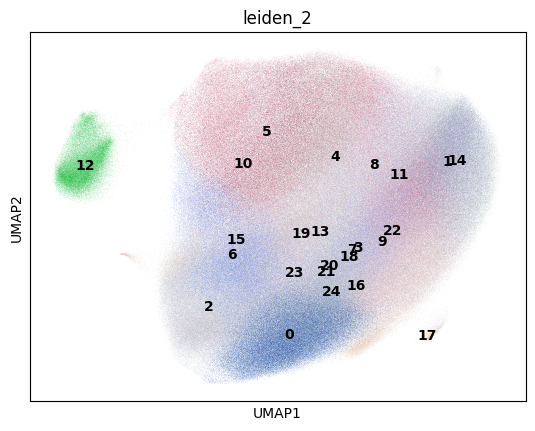

In [30]:
sc.pl.umap(adata, color = 'leiden_2', legend_loc = 'on data')

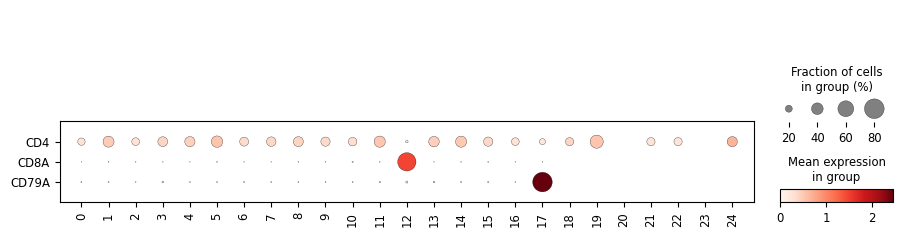

In [31]:
sc.pl.dotplot(adata, groupby = 'leiden_2', var_names = ['CD4','CD8A','CD79A'], swap_axes = True)

### CD79A Selection

Filtering

In [32]:
adata, n_removed = remove_cl(
    adata, 'CD79A', 'above', 0.6, 'leiden_2'
)
n_removed

['17']


1054

Reason

In [33]:
update_df = pd.DataFrame(
    {'AIFI_L3': [cell_type],
     'update_type': ['remove'],
     'n_total': [total_cells],
     'n_updated': [n_removed],
     'change_to': ['T cell doublet']
    }
)
update_list.append(update_df)

### CD8A Extraction

Extraction

In [34]:
cd4_mem_cd8a_adata, n_extracted = extract_cl(
    adata, 'CD8A', 'above', 0.4, 'leiden_2'
)
cd4_mem_cd8a_adata.obs['AIFI_L3'] = 'CD8 TBD'
n_extracted

['12']


62120

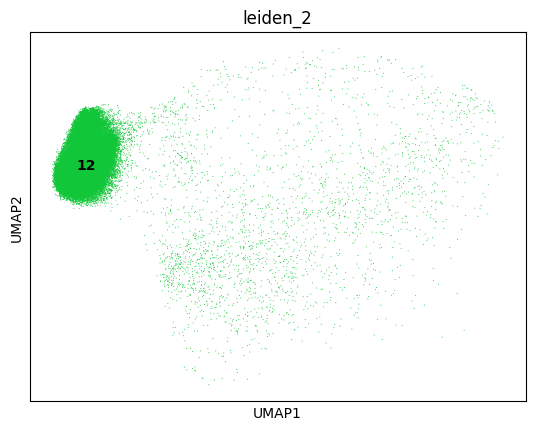

In [35]:
sc.pl.umap(cd4_mem_cd8a_adata, color = 'leiden_2', legend_loc = 'on data')

Removal

In [36]:
adata, n_removed = remove_cl(
    adata, 'CD8A', 'above', 0.4, 'leiden_2'
)
n_removed

['12']


62120

Reason

In [37]:
update_df = pd.DataFrame(
    {'AIFI_L3': [cell_type],
     'update_type': ['reassign'],
     'n_total': [total_cells],
     'n_updated': [n_removed],
     'change_to': ['CD8 TBD']
    }
)
update_list.append(update_df)

### Save extracted CD8A cells

In [38]:
out_file = 'output/diha_extracted_celltypist_L3_cd4-memory_cd8a-pos_{d}.h5ad'.format(d = date.today())
cd4_mem_cd8a_adata.write_h5ad(out_file)
out_files.append(out_file)

### Reprocess filtered cells

In [39]:
adata = process_adata(adata, resolution = 2)
adata = propagate_hierarchy(adata, hierarchy_df)

Normalizing; WARNING: adata.X seems to be already log-transformed.
Finding HVGs; Scaling; PCA; Neighbors; Leiden; UMAP; 

IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out


Renormalizing


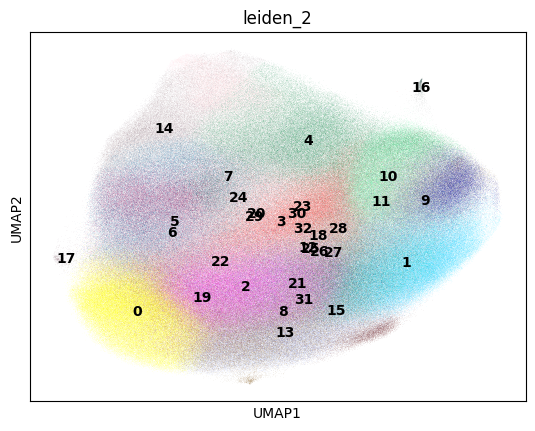

In [40]:
sc.pl.umap(adata, color = 'leiden_2', legend_loc = 'on data')

### Save filtered cells

In [41]:
out_type = format_cell_type(cell_type)
out_file = 'output/diha_filtered_celltypist_L3_{ot}_{d}.h5ad'.format(ot = out_type, d = date.today())
adata.write_h5ad(out_file)
out_files.append(out_file)

## Review Core naive CD4 T cell

### Proposed updates

- Remove high HBB cluster (16) as Erythrocyte doublet  
- Remove low marker expression cluster (15) as low-quality

In [42]:
cell_type = 'Core naive CD4 T cell'
type_uuid = search_df['id'].loc[search_df['AIFI_L3'] == cell_type].tolist()[0]

In [43]:
type_uuid

'c1a418fe-1bd0-49f1-b9b5-47916d239ca9'

In [44]:
adata = read_adata_uuid(type_uuid)
total_cells = adata.shape[0]

In [45]:
adata.obs['predicted_AIFI_L3'] = adata.obs['AIFI_L3']

### Clustering

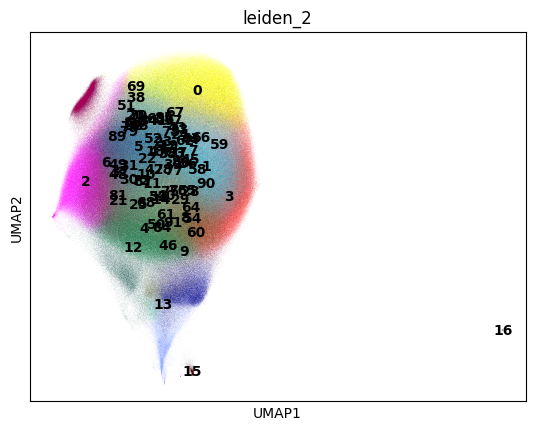

In [46]:
sc.pl.umap(adata, color = 'leiden_2', legend_loc = 'on data')

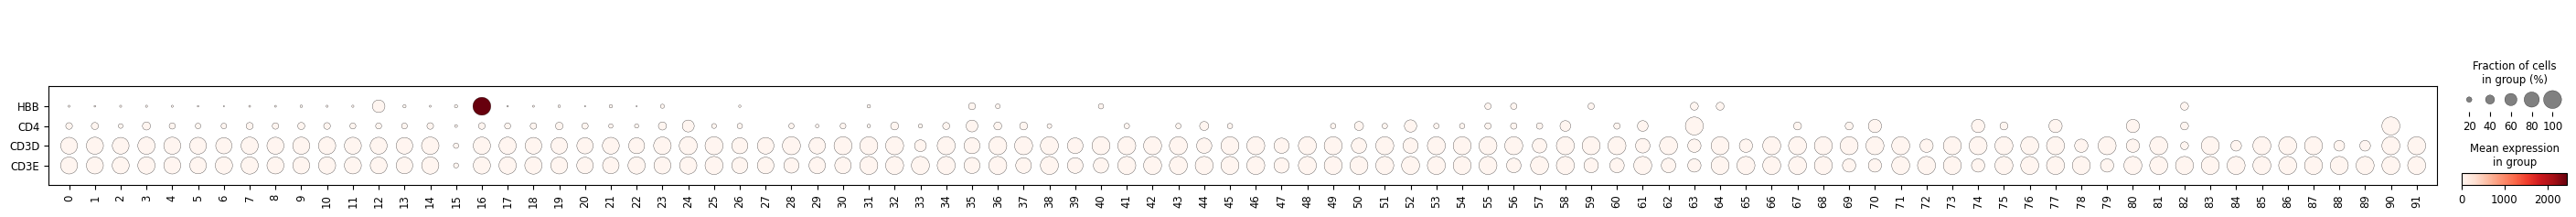

In [47]:
sc.pl.dotplot(adata, groupby = 'leiden_2', var_names = ['HBB','CD4','CD3D', 'CD3E'], swap_axes = True)

### HBB Selection

Filtering

In [48]:
adata, n_removed = remove_cl(
    adata, 'HBB', 'above', 0.8, 'leiden_2'
)
n_removed

['16']


1017

Reason

In [49]:
update_df = pd.DataFrame(
    {'AIFI_L3': [cell_type],
     'update_type': ['remove'],
     'n_total': [total_cells],
     'n_updated': [n_removed],
     'change_to': ['Erythrocyte doublet']
    }
)
update_list.append(update_df)

### Low CD3E Selection

Filtering

In [50]:
adata, n_removed = remove_cl(
    adata, 'CD3E', 'below', 0.4, 'leiden_2'
)
n_removed

['15']


4072

Reason

In [51]:
update_df = pd.DataFrame(
    {'AIFI_L3': [cell_type],
     'update_type': ['remove'],
     'n_total': [total_cells],
     'n_updated': [n_removed],
     'change_to': ['Low quality']
    }
)
update_list.append(update_df)

### Reprocess filtered cells

In [52]:
adata = process_adata(adata, resolution = 2)
adata = propagate_hierarchy(adata, hierarchy_df)

Normalizing; WARNING: adata.X seems to be already log-transformed.
Finding HVGs; Scaling; PCA; Neighbors; Leiden; 

IOStream.flush timed out


UMAP; 

IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out


Renormalizing


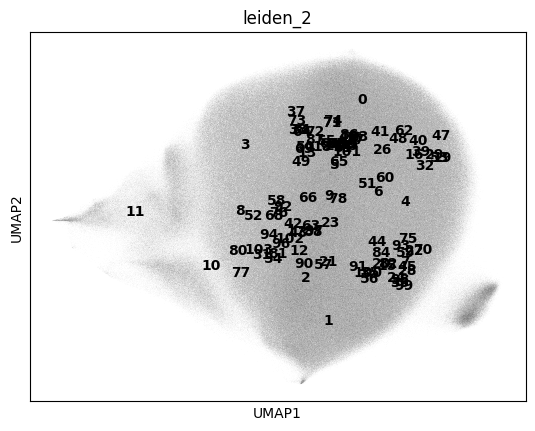

In [53]:
sc.pl.umap(adata, color = 'leiden_2', legend_loc = 'on data')

### Save filtered cells

In [54]:
out_type = format_cell_type(cell_type)
out_file = 'output/diha_filtered_celltypist_L3_{ot}_{d}.h5ad'.format(ot = out_type, d = date.today())
adata.write_h5ad(out_file)
out_files.append(out_file)

## Review GZMB- CD27- EM CD4 T cell

### Proposed updates

- Remove high CD79A cluster (18) as B cell doublet  
- Remove high CD8A cluster (12) as Mislabeled  
    - Re-cluster with CD8 cells to assign final clusters
- Remove low marker detection cluster (17) as low-quality

In [146]:
cell_type = 'GZMB- CD27- EM CD4 T cell'
type_uuid = search_df['id'].loc[search_df['AIFI_L3'] == cell_type].tolist()[0]

In [147]:
type_uuid

'b17c91af-2017-4476-84a3-59a5bbe0ecb4'

In [148]:
adata = read_adata_uuid(type_uuid)
total_cells = adata.shape[0]

In [149]:
adata.obs['predicted_AIFI_L3'] = adata.obs['AIFI_L3']

### Clustering

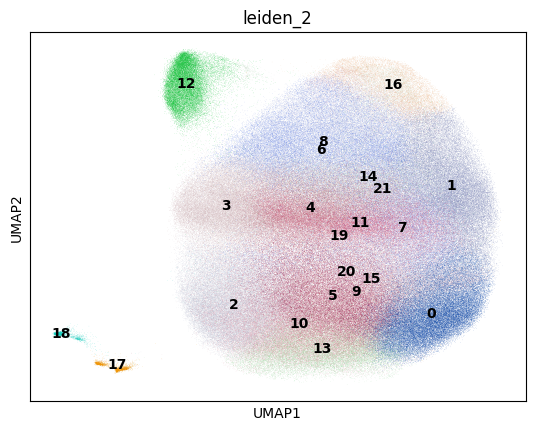

In [150]:
sc.pl.umap(adata, color = 'leiden_2', legend_loc = 'on data')

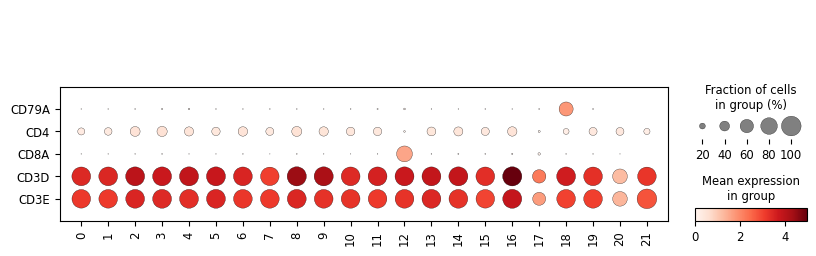

In [151]:
sc.pl.dotplot(adata, groupby = 'leiden_2', var_names = ['CD79A','CD4','CD8A','CD3D','CD3E'], swap_axes = True)

### CD79A Selection

Filtering

In [152]:
adata, n_removed = remove_cl(
    adata, 'CD79A', 'above', 0.6, 'leiden_2'
)
n_removed

['18']


2781

Reason

In [153]:
update_df = pd.DataFrame(
    {'AIFI_L3': [cell_type],
     'update_type': ['remove'],
     'n_total': [total_cells],
     'n_updated': [n_removed],
     'change_to': ['B cell doublet']
    }
)
update_list.append(update_df)

### Low CD3D Selection

Filtering

In [154]:
adata, n_removed = remove_cl(
    adata, 'CD3D', 'below', 0.7, 'leiden_2'
)
n_removed

['17', '20']


3282

Reason

In [155]:
update_df = pd.DataFrame(
    {'AIFI_L3': [cell_type],
     'update_type': ['remove'],
     'n_total': [total_cells],
     'n_updated': [n_removed],
     'change_to': ['Low quality']
    }
)
update_list.append(update_df)

### CD8A Extraction

Extraction

In [156]:
cd4_mem_cd8a_adata, n_extracted = extract_cl(
    adata, 'CD8A', 'above', 0.4, 'leiden_2'
)
cd4_mem_cd8a_adata.obs['AIFI_L3'] = 'CD8 TBD'
n_extracted

['12']


26498

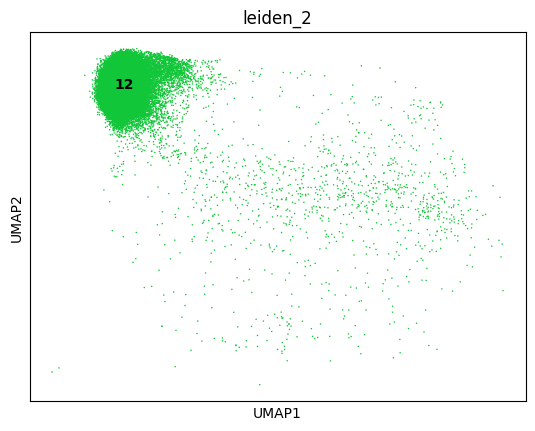

In [157]:
sc.pl.umap(cd4_mem_cd8a_adata, color = 'leiden_2', legend_loc = 'on data')

Removal

In [158]:
adata, n_removed = remove_cl(
    adata, 'CD8A', 'above', 0.4, 'leiden_2'
)
n_removed

['12']


26498

Reason

In [159]:
update_df = pd.DataFrame(
    {'AIFI_L3': [cell_type],
     'update_type': ['reassign'],
     'n_total': [total_cells],
     'n_updated': [n_removed],
     'change_to': ['CD8 TBD']
    }
)
update_list.append(update_df)

### Save extracted CD8A cells

In [ ]:
out_file = 'output/diha_extracted_celltypist_L3_cd4-em-gzmb-neg-cd27-neg_cd8a-pos_{d}.h5ad'.format(ot = out_type, d = date.today())
cd4_mem_cd8a_adata.write_h5ad(out_file)

In [ ]:
out_files.append(out_file)

### Reprocess filtered cells

In [160]:
adata = process_adata(adata, resolution = 2)
adata = propagate_hierarchy(adata, hierarchy_df)

Normalizing; WARNING: adata.X seems to be already log-transformed.
Finding HVGs; Scaling; PCA; Neighbors; Leiden; UMAP; Renormalizing


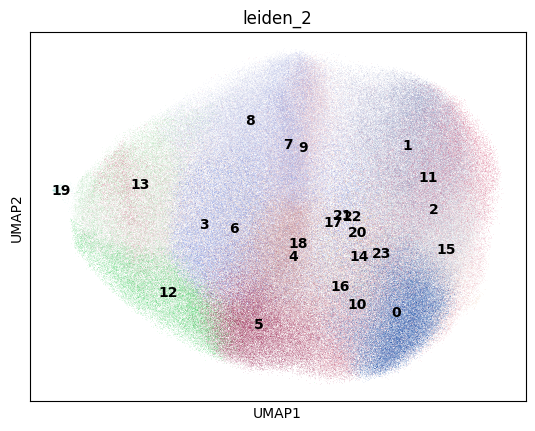

In [161]:
sc.pl.umap(adata, color = 'leiden_2', legend_loc = 'on data')

### Save filtered cells

In [162]:
out_type = format_cell_type(cell_type)
out_file = 'output/diha_filtered_celltypist_L3_{ot}_{d}.h5ad'.format(ot = out_type, d = date.today())
adata.write_h5ad(out_file)

In [ ]:
out_files.append(out_file)

## Review GZMB- CD27+ EM CD4 T cell

### Proposed updates

- Remove high CD8A cluster (13) as Mislabeled  
    - Re-cluster with CD8 cells to assign final clusters

In [73]:
cell_type = 'GZMB- CD27+ EM CD4 T cell'
type_uuid = search_df['id'].loc[search_df['AIFI_L3'] == cell_type].tolist()[0]

In [74]:
type_uuid

'94e9d829-0757-4266-b8a1-2b4b59b1f67e'

In [75]:
adata = read_adata_uuid(type_uuid)
total_cells = adata.shape[0]

In [76]:
adata.obs['predicted_AIFI_L3'] = adata.obs['AIFI_L3']

### Clustering

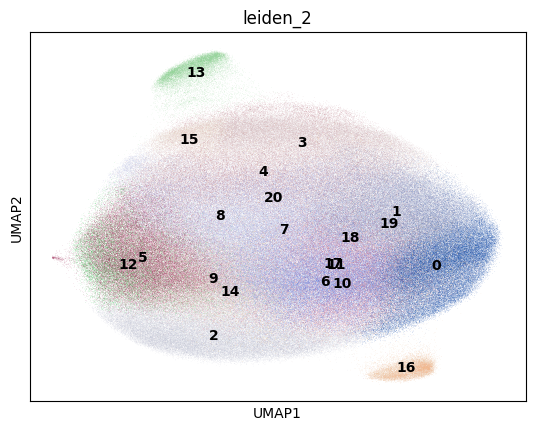

In [77]:
sc.pl.umap(adata, color = 'leiden_2', legend_loc = 'on data')

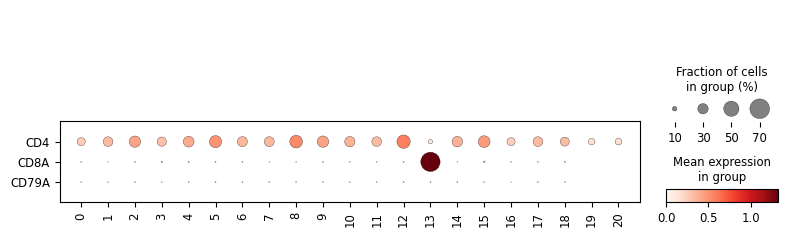

In [78]:
sc.pl.dotplot(adata, groupby = 'leiden_2', var_names = ['CD4','CD8A','CD79A'], swap_axes = True)

### CD8A Extraction

Extraction

In [79]:
cd4_mem_cd8a_adata, n_extracted = extract_cl(
    adata, 'CD8A', 'above', 0.4, 'leiden_2'
)
cd4_mem_cd8a_adata.obs['AIFI_L3'] = 'CD8 TBD'
n_extracted

['13']


18242

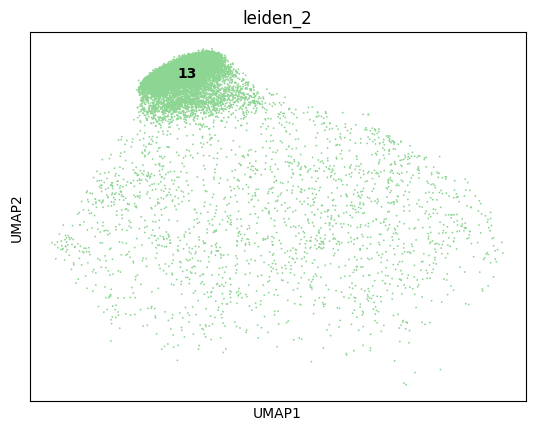

In [80]:
sc.pl.umap(cd4_mem_cd8a_adata, color = 'leiden_2', legend_loc = 'on data')

Removal

In [81]:
adata, n_removed = remove_cl(
    adata, 'CD8A', 'above', 0.4, 'leiden_2'
)
n_removed

['13']


18242

Reason

In [82]:
update_df = pd.DataFrame(
    {'AIFI_L3': [cell_type],
     'update_type': ['reassign'],
     'n_total': [total_cells],
     'n_updated': [n_removed],
     'change_to': ['CD8 TBD']
    }
)
update_list.append(update_df)

### Save extracted CD8A cells

In [83]:
out_file = 'output/diha_extracted_celltypist_L3_cd4-mem-gzmb-neg-cd27-pos_cd8a-pos_{d}.h5ad'.format(d = date.today())
cd4_mem_cd8a_adata.write_h5ad(out_file)
out_files.append(out_file)

### Reprocess filtered cells

In [84]:
adata = process_adata(adata, resolution = 2)
adata = propagate_hierarchy(adata, hierarchy_df)

Normalizing; WARNING: adata.X seems to be already log-transformed.
Finding HVGs; Scaling; PCA; Neighbors; Leiden; UMAP; Renormalizing


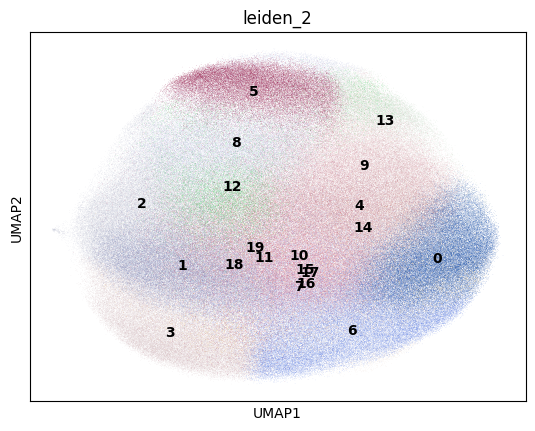

In [85]:
sc.pl.umap(adata, color = 'leiden_2', legend_loc = 'on data')

### Save filtered cells

In [86]:
out_type = format_cell_type(cell_type)
out_file = 'output/diha_filtered_celltypist_L3_{ot}_{d}.h5ad'.format(ot = out_type, d = date.today())
adata.write_h5ad(out_file)
out_files.append(out_file)

## Review ISG+ memory CD4 T cell

### Proposed updates

- Remove high CD8A cluster (16) as Mislabeled  
- Remove high FCN1 cluster (23) as Myeloid doublet

In [87]:
cell_type = 'ISG+ memory CD4 T cell'
type_uuid = search_df['id'].loc[search_df['AIFI_L3'] == cell_type].tolist()[0]

In [88]:
type_uuid

'63124b2a-4d52-4e2e-a212-cb08e5d36ce2'

In [89]:
adata = read_adata_uuid(type_uuid)
total_cells = adata.shape[0]

In [90]:
adata.obs['predicted_AIFI_L3'] = adata.obs['AIFI_L3']

### Clustering

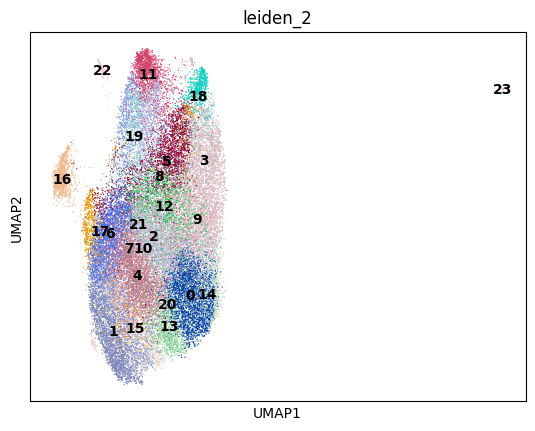

In [91]:
sc.pl.umap(adata, color = 'leiden_2', legend_loc = 'on data')

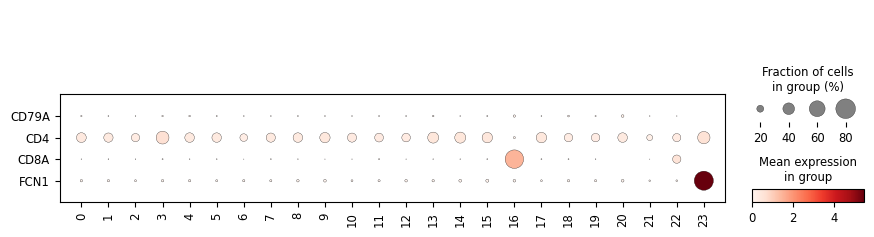

In [92]:
sc.pl.dotplot(adata, groupby = 'leiden_2', var_names = ['CD79A','CD4','CD8A','FCN1'], swap_axes = True)

### CD8A Selection

Filtering

In [93]:
adata, n_removed = remove_cl(
    adata, 'CD8A', 'above', 0.2, 'leiden_2'
)
n_removed

['16', '22']


1272

Reason

In [94]:
update_df = pd.DataFrame(
    {'AIFI_L3': [cell_type],
     'update_type': ['remove'],
     'n_total': [total_cells],
     'n_updated': [n_removed],
     'change_to': ['CD8 doublet']
    }
)
update_list.append(update_df)

### FCN1 Selection

Filtering

In [95]:
adata, n_removed = remove_cl(
    adata, 'FCN1', 'above', 0.6, 'leiden_2'
)
n_removed

['23']


44

Reason

In [96]:
update_df = pd.DataFrame(
    {'AIFI_L3': [cell_type],
     'update_type': ['remove'],
     'n_total': [total_cells],
     'n_updated': [n_removed],
     'change_to': ['Myeloid doublet']
    }
)
update_list.append(update_df)

### Reprocess filtered cells

In [97]:
adata = process_adata(adata, resolution = 2)
adata = propagate_hierarchy(adata, hierarchy_df)

Normalizing; WARNING: adata.X seems to be already log-transformed.
Finding HVGs; Scaling; PCA; Neighbors; Leiden; UMAP; Renormalizing


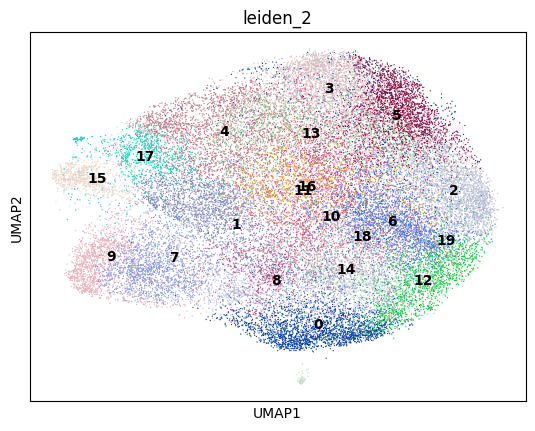

In [98]:
sc.pl.umap(adata, color = 'leiden_2', legend_loc = 'on data')

### Save filtered cells

In [99]:
out_type = format_cell_type(cell_type)
out_file = 'output/diha_filtered_celltypist_L3_{ot}_{d}.h5ad'.format(ot = out_type, d = date.today())
adata.write_h5ad(out_file)
out_files.append(out_file)

## Review ISG+ naive CD4 T cell

### Proposed updates

- Remove high CD8A cluster (19) as Mislabeled  

In [100]:
cell_type = 'ISG+ naive CD4 T cell'
type_uuid = search_df['id'].loc[search_df['AIFI_L3'] == cell_type].tolist()[0]

In [ ]:
type_uuid

'879fa7c3-ca46-4dad-8993-3579338db98f'

In [ ]:
adata = read_adata_uuid(type_uuid)
total_cells = adata.shape[0]

In [ ]:
adata.obs['predicted_AIFI_L3'] = adata.obs['AIFI_L3']

### Clustering

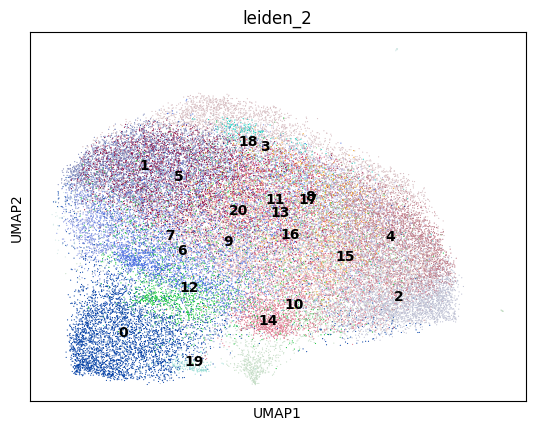

In [ ]:
sc.pl.umap(adata, color = 'leiden_2', legend_loc = 'on data')

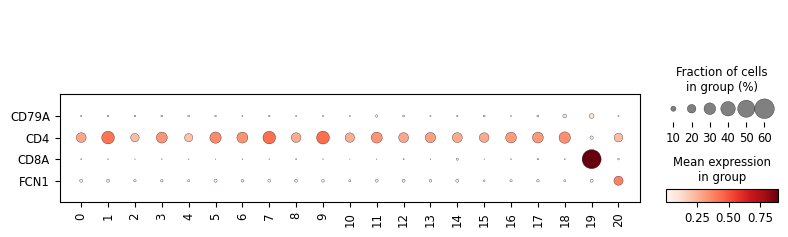

In [ ]:
sc.pl.dotplot(adata, groupby = 'leiden_2', var_names = ['CD79A','CD4','CD8A','FCN1'], swap_axes = True)

### CD8A Selection

Filtering

In [ ]:
adata, n_removed = remove_cl(
    adata, 'CD8A', 'above', 0.2, 'leiden_2'
)
n_removed

['19']


322

Reason

In [ ]:
update_df = pd.DataFrame(
    {'AIFI_L3': [cell_type],
     'update_type': ['remove'],
     'n_total': [total_cells],
     'n_updated': [n_removed],
     'change_to': ['CD8 doublet']
    }
)
update_list.append(update_df)

### FCN1 Selection

Filtering

In [ ]:
adata, n_removed = remove_cl(
    adata, 'FCN1', 'above', 0.1, 'leiden_2'
)
n_removed

['20']


134

Reason

In [ ]:
update_df = pd.DataFrame(
    {'AIFI_L3': [cell_type],
     'update_type': ['remove'],
     'n_total': [total_cells],
     'n_updated': [n_removed],
     'change_to': ['Myeloid doublet']
    }
)
update_list.append(update_df)

### Reprocess filtered cells

In [ ]:
adata = process_adata(adata, resolution = 2)
adata = propagate_hierarchy(adata, hierarchy_df)

Normalizing; WARNING: adata.X seems to be already log-transformed.
Finding HVGs; Scaling; PCA; Neighbors; Leiden; UMAP; Renormalizing


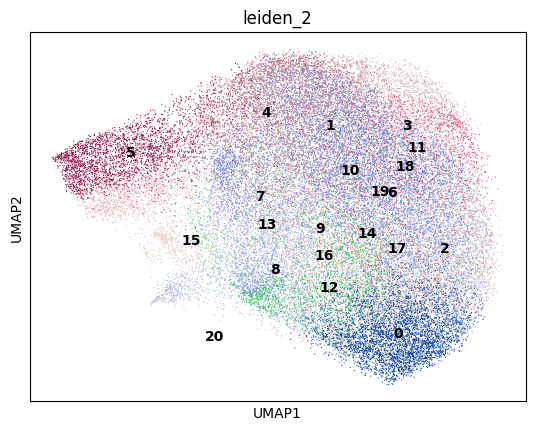

In [ ]:
sc.pl.umap(adata, color = 'leiden_2', legend_loc = 'on data')

### Save filtered cells

In [ ]:
out_type = format_cell_type(cell_type)
out_file = 'output/diha_filtered_celltypist_L3_{ot}_{d}.h5ad'.format(ot = out_type, d = date.today())
adata.write_h5ad(out_file)
out_files.append(out_file)

## Review KLRF1- GZMB+ CD27- memory CD4 T cell

### Proposed updates

- Remove high CD8A cluster (17) as mislabeled
    - Re-cluster with CD8 cells to assign final clusters

In [ ]:
cell_type = 'KLRF1- GZMB+ CD27- memory CD4 T cell'
type_uuid = search_df['id'].loc[search_df['AIFI_L3'] == cell_type].tolist()[0]

In [ ]:
type_uuid

'1252fd26-a9a6-41a6-b983-a796eee75c5c'

In [ ]:
adata = read_adata_uuid(type_uuid)
total_cells = adata.shape[0]

In [ ]:
adata.obs['predicted_AIFI_L3'] = adata.obs['AIFI_L3']

### Clustering

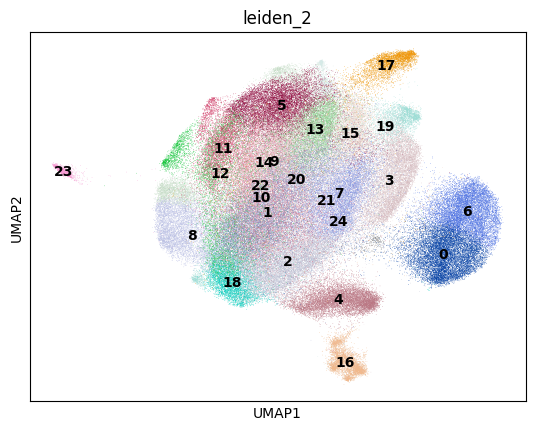

In [ ]:
sc.pl.umap(adata, color = 'leiden_2', legend_loc = 'on data')

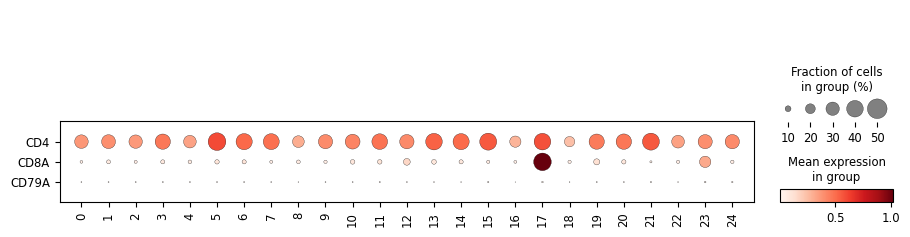

In [ ]:
sc.pl.dotplot(adata, groupby = 'leiden_2', var_names = ['CD4','CD8A','CD79A'], swap_axes = True)

### CD8A Extraction

Extraction

In [ ]:
cd4_mem_cd8a_adata, n_extracted = extract_cl(
    adata, 'CD8A', 'above', 0.4, 'leiden_2'
)
cd4_mem_cd8a_adata.obs['AIFI_L3'] = 'CD8 TBD'
n_extracted

['17']


4605

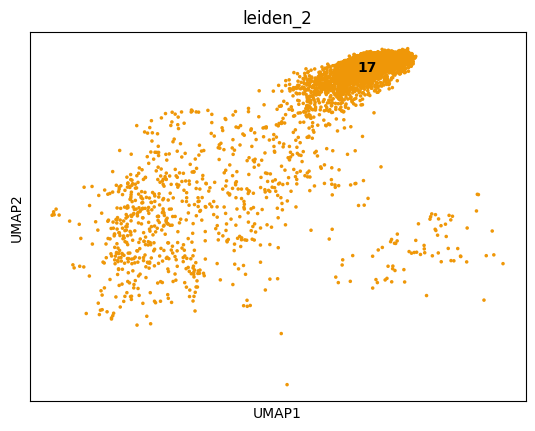

In [ ]:
sc.pl.umap(cd4_mem_cd8a_adata, color = 'leiden_2', legend_loc = 'on data')

Removal

In [ ]:
adata, n_removed = remove_cl(
    adata, 'CD8A', 'above', 0.4, 'leiden_2'
)
n_removed

['17']


4605

Reason

In [ ]:
update_df = pd.DataFrame(
    {'AIFI_L3': [cell_type],
     'update_type': ['reassign'],
     'n_total': [total_cells],
     'n_updated': [n_removed],
     'change_to': ['CD8 TBD']
    }
)
update_list.append(update_df)

### Save extracted CD8A cells

In [ ]:
out_file = 'output/diha_extracted_celltypist_L3_cd4-mem-klrf1-neg_cd8a-pos_{d}.h5ad'.format(d = date.today())
cd4_mem_cd8a_adata.write_h5ad(out_file)
out_files.append(out_file)

### Reprocess filtered cells

In [ ]:
adata = process_adata(adata, resolution = 2)
adata = propagate_hierarchy(adata, hierarchy_df)

Normalizing; WARNING: adata.X seems to be already log-transformed.
Finding HVGs; Scaling; PCA; Neighbors; Leiden; UMAP; Renormalizing


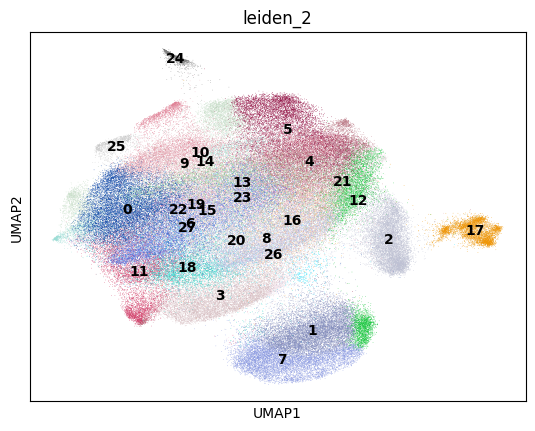

In [ ]:
sc.pl.umap(adata, color = 'leiden_2', legend_loc = 'on data')

### Save filtered cells

In [ ]:
out_type = format_cell_type(cell_type)
out_file = 'output/diha_filtered_celltypist_L3_{ot}_{d}.h5ad'.format(ot = out_type, d = date.today())
adata.write_h5ad(out_file)
out_files.append(out_file)

## Review SOX4+ naive CD4 T cell

### Proposed updates

- Remove high CD8A cluster (15) as mislabeled
- Remove high TRDC cluster (4) as mislabeled

In [ ]:
cell_type = 'SOX4+ naive CD4 T cell'
type_uuid = search_df['id'].loc[search_df['AIFI_L3'] == cell_type].tolist()[0]

In [ ]:
type_uuid

'4965e9bf-e802-49c1-a23d-a2c8c53828e0'

In [ ]:
adata = read_adata_uuid(type_uuid)
total_cells = adata.shape[0]

In [ ]:
adata.obs['predicted_AIFI_L3'] = adata.obs['AIFI_L3']

### Clustering

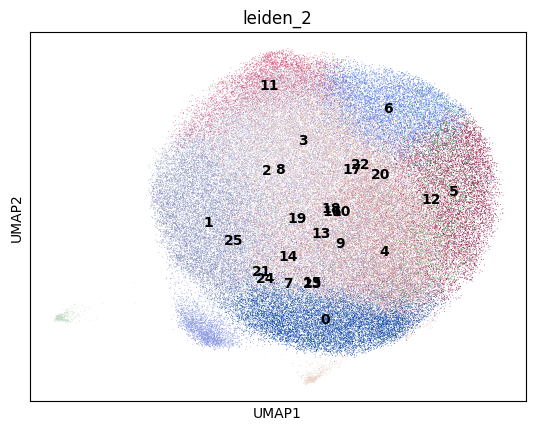

In [ ]:
sc.pl.umap(adata, color = 'leiden_2', legend_loc = 'on data')

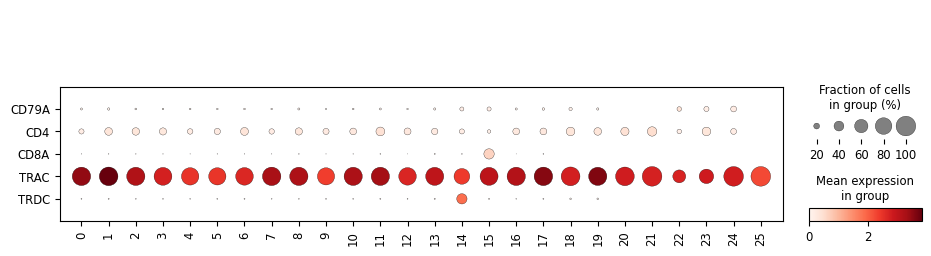

In [ ]:
sc.pl.dotplot(adata, groupby = 'leiden_2', var_names = ['CD79A','CD4','CD8A','TRAC','TRDC'], swap_axes = True)

### CD8A Selection

Filtering

In [ ]:
adata, n_removed = remove_cl(
    adata, 'CD8A', 'above', 0.2, 'leiden_2'
)
n_removed

['15']


1329

Reason

In [ ]:
update_df = pd.DataFrame(
    {'AIFI_L3': [cell_type],
     'update_type': ['remove'],
     'n_total': [total_cells],
     'n_updated': [n_removed],
     'change_to': ['CD8 doublet']
    }
)
update_list.append(update_df)

### TRDC Selection

Filtering

In [ ]:
adata, n_removed = remove_cl(
    adata, 'TRDC', 'above', 0.2, 'leiden_2'
)
n_removed

['14']


1418

Reason

In [ ]:
update_df = pd.DataFrame(
    {'AIFI_L3': [cell_type],
     'update_type': ['remove'],
     'n_total': [total_cells],
     'n_updated': [n_removed],
     'change_to': ['gdT doublet']
    }
)
update_list.append(update_df)

### Reprocess filtered cells

In [ ]:
adata = process_adata(adata, resolution = 2)
adata = propagate_hierarchy(adata, hierarchy_df)

Normalizing; WARNING: adata.X seems to be already log-transformed.
Finding HVGs; Scaling; PCA; Neighbors; Leiden; UMAP; Renormalizing


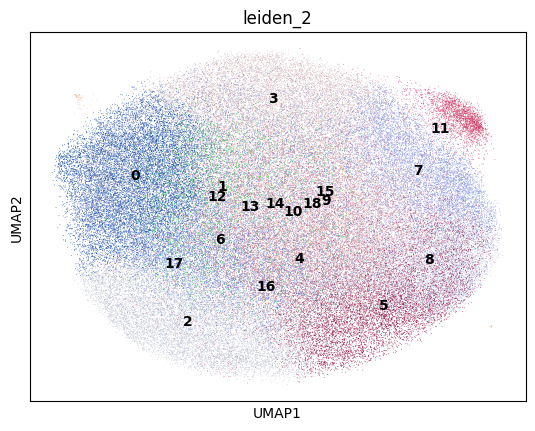

In [ ]:
sc.pl.umap(adata, color = 'leiden_2', legend_loc = 'on data')

### Save filtered cells

In [41]:
out_type = format_cell_type(cell_type)
out_file = 'output/diha_filtered_celltypist_L3_{ot}_{d}.h5ad'.format(ot = out_type, d = date.today())
adata.write_h5ad(out_file)
out_files.append(out_file)

## Assemble update reasoning

In [163]:
update_df = pd.concat(update_list)

In [164]:
update_df

AIFI_L3 update_type  n_total  n_updated  \
0                         CM CD4 T cell      remove  1424598       1054   
0                         CM CD4 T cell    reassign  1424598      62120   
0                 Core naive CD4 T cell      remove  2704765       1017   
0                 Core naive CD4 T cell      remove  2704765       4072   
0                 ISG+ naive CD4 T cell      remove    43861        322   
0                 ISG+ naive CD4 T cell      remove    43861        134   
0  KLRF1- GZMB+ CD27- memory CD4 T cell    reassign   160915       4605   
0                SOX4+ naive CD4 T cell      remove    99886       1329   
0                SOX4+ naive CD4 T cell      remove    99886       1418   
0             GZMB- CD27- EM CD4 T cell      remove   534020       2781   
0             GZMB- CD27- EM CD4 T cell      remove   534020       3282   
0             GZMB- CD27- EM CD4 T cell    reassign   534020      26498   

             change_to  
0       T cell doublet  
0              CD8 TBD  
0  Erythrocyte doublet  
0          Low quality  
0          CD8 doublet  
0      Myeloid doublet  
0              CD8 TBD  
0          CD8 doublet  
0          gdT doublet  
0       B cell doublet  
0          Low quality  
0              CD8 TBD

In [165]:
out_update = 'output/diha_filtered_celltypist_L3_CD4_reasons_{d}.csv'.format(d = date.today())
update_df.to_csv(out_update)
out_files.append(out_update)

## Upload Cell Type data to HISE

Finally, we'll use `hisepy.upload.upload_files()` to send a copy of our output to HISE to use for downstream analysis steps.

In [166]:
study_space_uuid = 'de025812-5e73-4b3c-9c3b-6d0eac412f2a'
title = 'DIHA CellTypist L3 CD8 Filtered {d}'.format(d = date.today())

In [167]:
search_id = element_id()
search_id

'roentgenium-bohrium-titanium'

In [168]:
in_files = search_df['id'].tolist()
in_files

['38827e4d-4b66-43eb-9d5a-1e749ffc38d2',
 'c1a418fe-1bd0-49f1-b9b5-47916d239ca9',
 'b17c91af-2017-4476-84a3-59a5bbe0ecb4',
 '94e9d829-0757-4266-b8a1-2b4b59b1f67e',
 '63124b2a-4d52-4e2e-a212-cb08e5d36ce2',
 '879fa7c3-ca46-4dad-8993-3579338db98f',
 '1252fd26-a9a6-41a6-b983-a796eee75c5c',
 '4965e9bf-e802-49c1-a23d-a2c8c53828e0']

In [172]:
out_files

['output/diha_extracted_celltypist_L3_cd4-memory_cd8a-pos_2024-04-19.h5ad',
 'output/diha_filtered_celltypist_L3_CM_CD4_T_cell_2024-04-19.h5ad',
 'output/diha_filtered_celltypist_L3_Core_naive_CD4_T_cell_2024-04-19.h5ad',
 'output/diha_extracted_celltypist_L3_cd4-em-gzmb-neg-cd27-neg_cd8a-pos_2024-04-19.h5ad',
 'output/diha_filtered_celltypist_L3_GZMBneg_CD27neg_EM_CD4_T_cell_2024-04-19.h5ad',
 'output/diha_extracted_celltypist_L3_cd4-mem-gzmb-neg-cd27-pos_cd8a-pos_2024-04-19.h5ad',
 'output/diha_filtered_celltypist_L3_GZMBneg_CD27pos_EM_CD4_T_cell_2024-04-19.h5ad',
 'output/diha_filtered_celltypist_L3_ISGpos_memory_CD4_T_cell_2024-04-19.h5ad',
 'output/diha_filtered_celltypist_L3_ISGpos_naive_CD4_T_cell_2024-04-19.h5ad',
 'output/diha_extracted_celltypist_L3_cd4-mem-klrf1-neg_cd8a-pos_2024-04-19.h5ad',
 'output/diha_filtered_celltypist_L3_KLRF1neg_GZMBpos_CD27neg_memory_CD4_T_cell_2024-04-19.h5ad',
 'output/diha_filtered_celltypist_L3_CD4_reasons_2024-04-19.csv']

In [173]:
hisepy.upload.upload_files(
    files = out_files,
    study_space_id = study_space_uuid,
    title = title,
    input_file_ids = in_files,
    destination = search_id
)

you are trying to upload file_ids... ['output/diha_extracted_celltypist_L3_cd4-memory_cd8a-pos_2024-04-19.h5ad', 'output/diha_filtered_celltypist_L3_CM_CD4_T_cell_2024-04-19.h5ad', 'output/diha_filtered_celltypist_L3_Core_naive_CD4_T_cell_2024-04-19.h5ad', 'output/diha_extracted_celltypist_L3_cd4-em-gzmb-neg-cd27-neg_cd8a-pos_2024-04-19.h5ad', 'output/diha_filtered_celltypist_L3_GZMBneg_CD27neg_EM_CD4_T_cell_2024-04-19.h5ad', 'output/diha_extracted_celltypist_L3_cd4-mem-gzmb-neg-cd27-pos_cd8a-pos_2024-04-19.h5ad', 'output/diha_filtered_celltypist_L3_GZMBneg_CD27pos_EM_CD4_T_cell_2024-04-19.h5ad', 'output/diha_filtered_celltypist_L3_ISGpos_memory_CD4_T_cell_2024-04-19.h5ad', 'output/diha_filtered_celltypist_L3_ISGpos_naive_CD4_T_cell_2024-04-19.h5ad', 'output/diha_extracted_celltypist_L3_cd4-mem-klrf1-neg_cd8a-pos_2024-04-19.h5ad', 'output/diha_filtered_celltypist_L3_KLRF1neg_GZMBpos_CD27neg_memory_CD4_T_cell_2024-04-19.h5ad', 'output/diha_filtered_celltypist_L3_CD4_reasons_2024-04-19.c

(y/n) y


{'trace_id': '85c38298-dedf-4871-a574-9fc448ca5e7a',
 'files': ['output/diha_extracted_celltypist_L3_cd4-memory_cd8a-pos_2024-04-19.h5ad',
  'output/diha_filtered_celltypist_L3_CM_CD4_T_cell_2024-04-19.h5ad',
  'output/diha_filtered_celltypist_L3_Core_naive_CD4_T_cell_2024-04-19.h5ad',
  'output/diha_extracted_celltypist_L3_cd4-em-gzmb-neg-cd27-neg_cd8a-pos_2024-04-19.h5ad',
  'output/diha_filtered_celltypist_L3_GZMBneg_CD27neg_EM_CD4_T_cell_2024-04-19.h5ad',
  'output/diha_extracted_celltypist_L3_cd4-mem-gzmb-neg-cd27-pos_cd8a-pos_2024-04-19.h5ad',
  'output/diha_filtered_celltypist_L3_GZMBneg_CD27pos_EM_CD4_T_cell_2024-04-19.h5ad',
  'output/diha_filtered_celltypist_L3_ISGpos_memory_CD4_T_cell_2024-04-19.h5ad',
  'output/diha_filtered_celltypist_L3_ISGpos_naive_CD4_T_cell_2024-04-19.h5ad',
  'output/diha_extracted_celltypist_L3_cd4-mem-klrf1-neg_cd8a-pos_2024-04-19.h5ad',
  'output/diha_filtered_celltypist_L3_KLRF1neg_GZMBpos_CD27neg_memory_CD4_T_cell_2024-04-19.h5ad',
  'output/diha

In [ ]:
import session_info
session_info.show()